### Importing required libraries, environment and data

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
!pip install pyreadr

# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyreadr
import seaborn as sns
import scipy.stats as stats
import torch
import lightgbm as lgb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf

sns.set()

     |████████████████████████████████| 419kB 6.7MB/s 
Mounted at /content/drive


In [ ]:
PATH = '/content/drive/MyDrive/Datasets/Tennessee Eastman Process/'

train_normal_path = PATH+'TEP_FaultFree_Training.RData'
#train_faulty_path = PATH+'TEP_Faulty_Training.RData'

#test_normal_path = PATH+'TEP_FaultFree_Testing.RData'
test_faulty_path = PATH+'TEP_Faulty_Testing.RData'

In [ ]:
train_df = pyreadr.read_r(train_normal_path)['fault_free_training']
#train_faulty = pyreadr.read_r(train_faulty_path)['faulty_training']

#test_normal = pyreadr.read_r(test_normal_path)['fault_free_testing']
test_df = pyreadr.read_r(test_faulty_path)['faulty_testing']

# LSTM
The Long Short Term Memory architecture was motivated by an analysis of error flow in existing RNNs which found that long time lags were inaccessible to existing architectures, because backpropagated error either blows up or decays exponentially.

An LSTM layer consists of a set of recurrently connected blocks, known as memory blocks. These blocks can be thought of as a differentiable version of the memory chips in a digital computer. Each one contains one or more recurrently connected memory cells and three multiplicative units – the input, output and forget gates – that provide continuous analogues of write, read and reset operations for the cells.

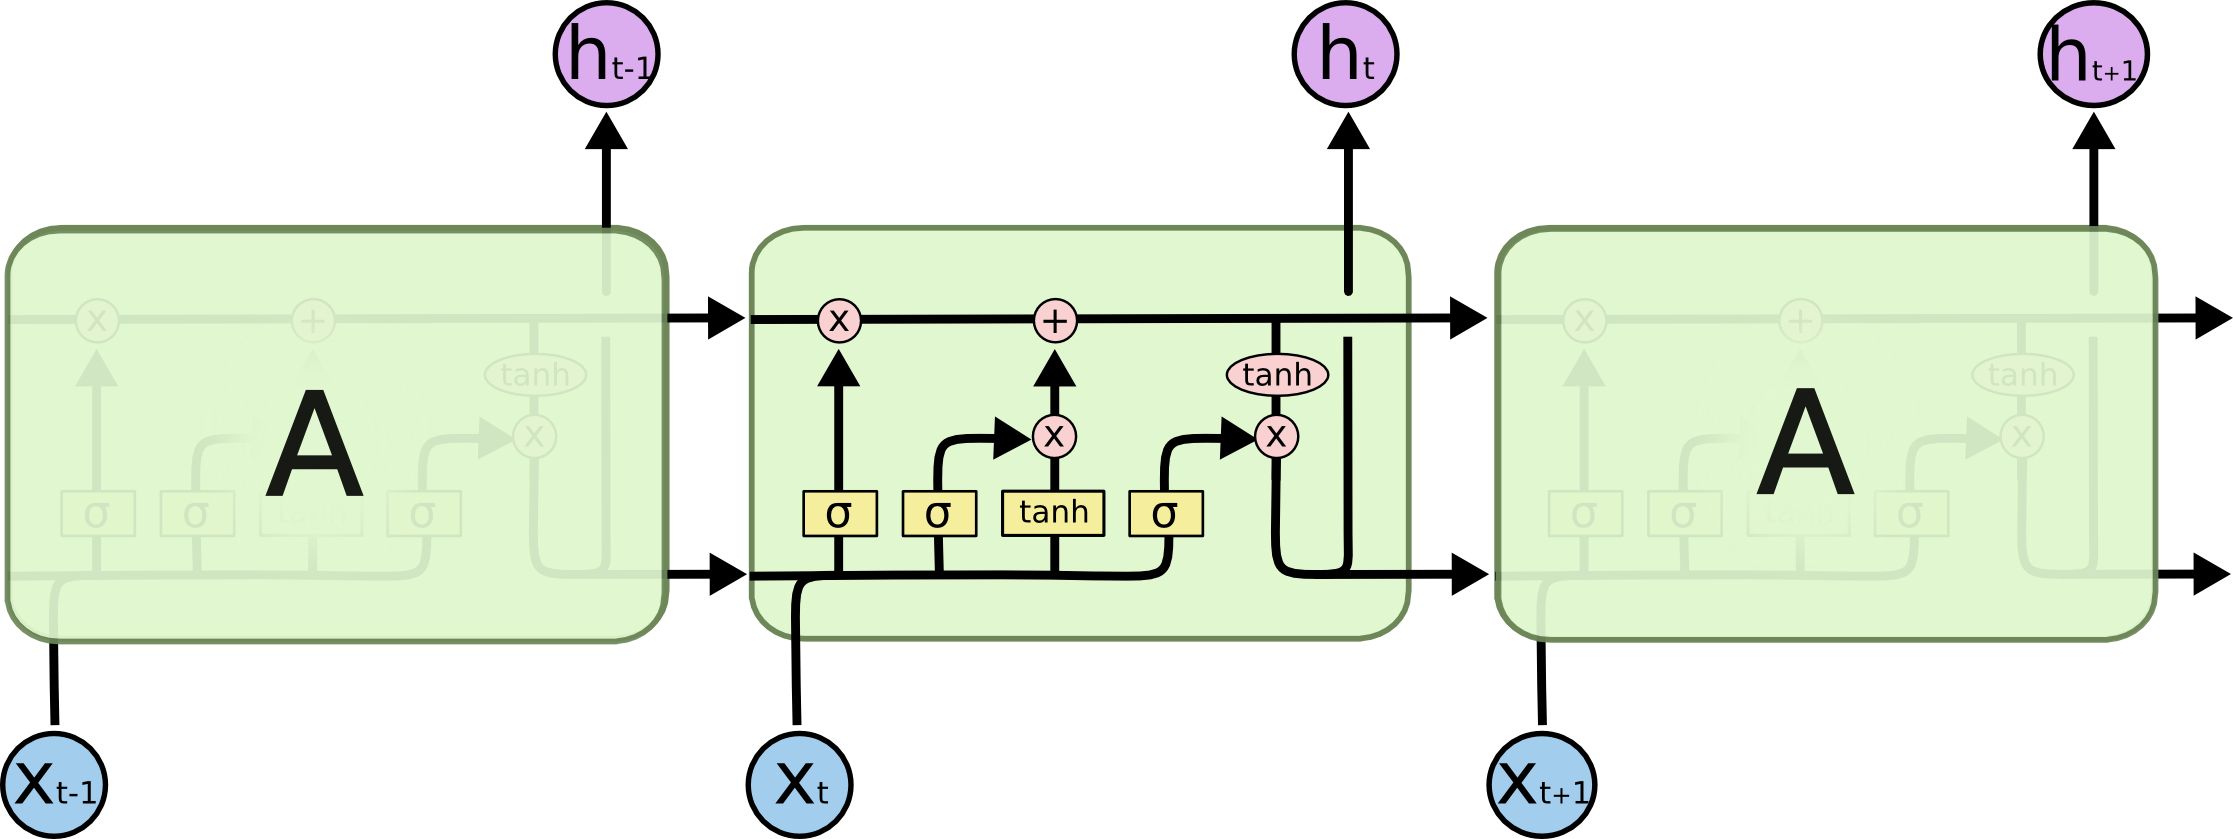

The two technical problems overcome by LSTMs are vanishing gradients and exploding gradients, both related to how the network is trained.

LSTMs are effective at capturing long-term temporal dependencies without suffering from the optimization hurdles

In [ ]:
def series_to_lstm(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
   
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%d(t-%d)' % (j, i)) for j in range(n_vars)]
   
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%d(t)' % (j)) for j in range(n_vars)]
        else:
            names += [('%d(t+%d)' % (j, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
scaler = preprocessing.MinMaxScaler()

dat = train_df[(train_df.faultNumber==0) & (train_df.simulationRun.isin(range(200)))]
dat = dat.iloc[:,3:]
dat = scaler.fit_transform(dat)
print(dat.shape)


test = train_df[(train_df.faultNumber==0) & (train_df.simulationRun.isin(range(400,500)))]
test = test.iloc[:,3:]
test = scaler.transform(test)
print(test.shape)

(99500, 52)
(50000, 52)


In [ ]:
time_steps = 10

ref = series_to_lstm(dat,time_steps,1)
print(ref.shape)

ref_test = series_to_lstm(test,time_steps,1)
print(ref_test.shape)

(99490, 572)
(49990, 572)


In [ ]:
train_x = ref.values[:,:-52]
train_y = ref.values[:,-52:]
train_x = train_x.reshape(train_x.shape[0],time_steps,train_x.shape[1]//time_steps)

test_x = ref_test.values[:,:-52]
test_y = ref_test.values[:,-52:]
test_x = test_x.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(99490, 10, 52)
(99490, 52)
(49990, 10, 52)
(49990, 52)


In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2])))
model_lstm.add(Dense(52))
model_lstm.compile(loss='mse', optimizer='adam')

history = model_lstm.fit(train_x, train_y, epochs=25, batch_size=50, validation_data=(test_x, test_y), verbose=2, shuffle=False)

Epoch 1/25
1990/1990 - 18s - loss: 0.0123 - val_loss: 0.0094
Epoch 2/25
1990/1990 - 14s - loss: 0.0086 - val_loss: 0.0080
Epoch 3/25
1990/1990 - 14s - loss: 0.0076 - val_loss: 0.0073
Epoch 4/25
1990/1990 - 14s - loss: 0.0072 - val_loss: 0.0071
Epoch 5/25
1990/1990 - 14s - loss: 0.0070 - val_loss: 0.0069
Epoch 6/25
1990/1990 - 14s - loss: 0.0069 - val_loss: 0.0068
Epoch 7/25
1990/1990 - 14s - loss: 0.0068 - val_loss: 0.0068
Epoch 8/25
1990/1990 - 14s - loss: 0.0067 - val_loss: 0.0067
Epoch 9/25
1990/1990 - 14s - loss: 0.0067 - val_loss: 0.0067
Epoch 10/25
1990/1990 - 14s - loss: 0.0067 - val_loss: 0.0067
Epoch 11/25
1990/1990 - 14s - loss: 0.0067 - val_loss: 0.0067
Epoch 12/25
1990/1990 - 14s - loss: 0.0066 - val_loss: 0.0066
Epoch 13/25
1990/1990 - 14s - loss: 0.0066 - val_loss: 0.0066
Epoch 14/25
1990/1990 - 14s - loss: 0.0066 - val_loss: 0.0066
Epoch 15/25
1990/1990 - 14s - loss: 0.0066 - val_loss: 0.0066
Epoch 16/25
1990/1990 - 14s - loss: 0.0066 - val_loss: 0.0066
Epoch 17/25
1990/

# Results and Conclusion

A more robust model, based on neural networks is made which shows better reults than statistical monitoring 

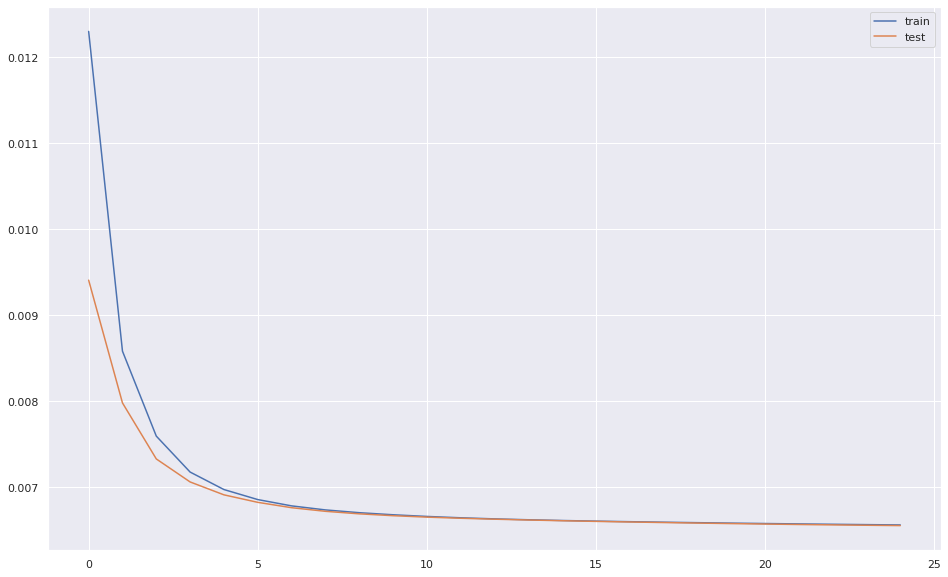

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

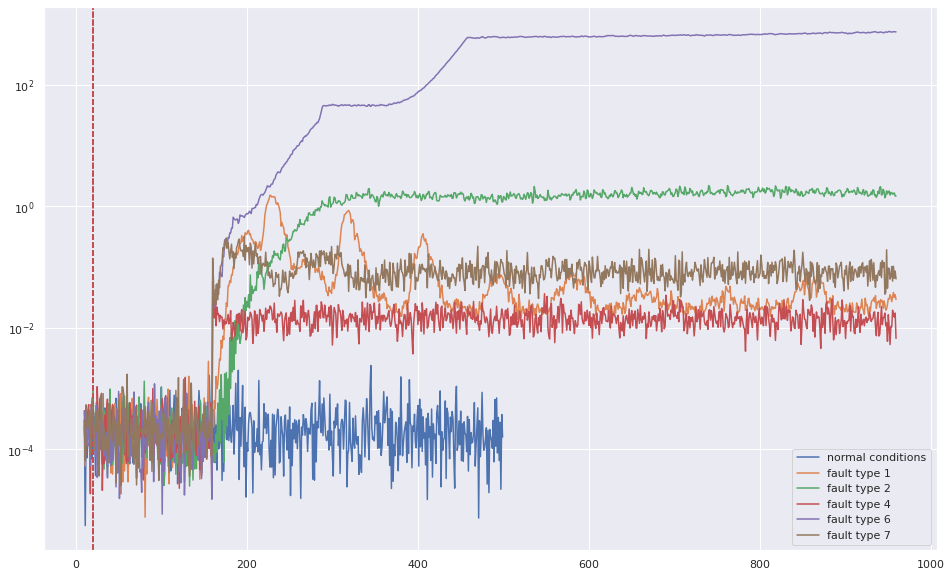

In [ ]:
plt.figure(figsize=(16,10))
plt.yscale('log')

for i in [0,1,2,4,6,7]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

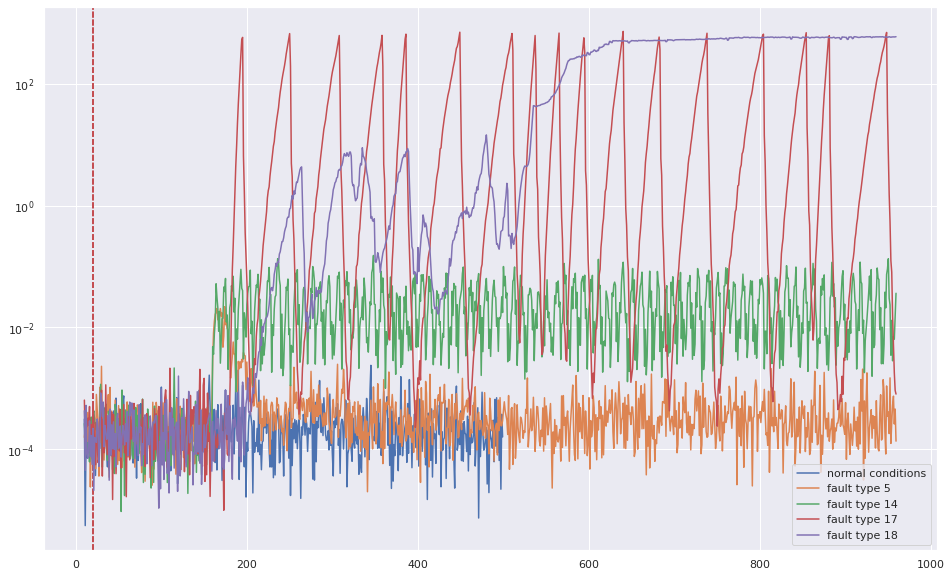

In [ ]:
plt.figure(figsize=(16,10))
plt.yscale('log')

for i in [0,5,14,17,18]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

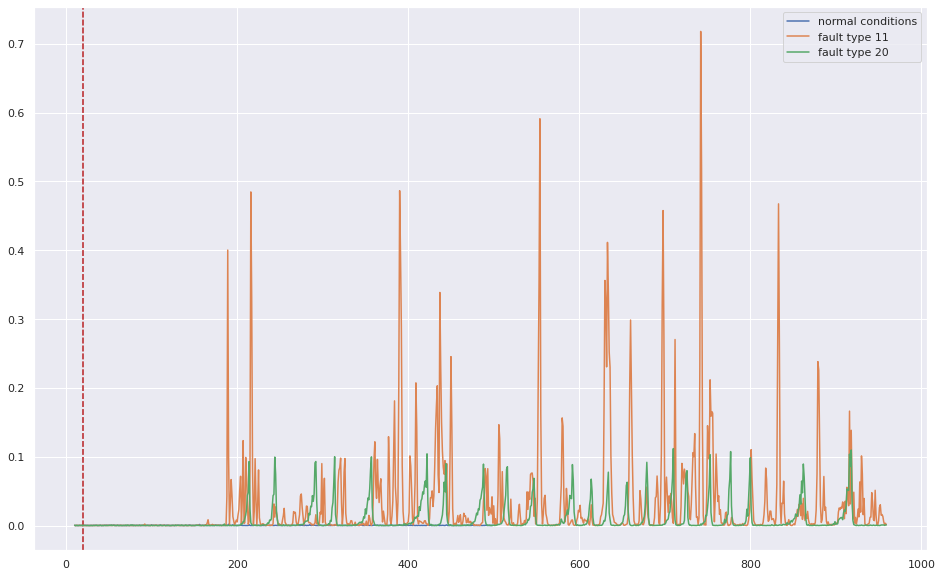

In [ ]:
plt.figure(figsize=(16,10))

for i in [0,11,20]:
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

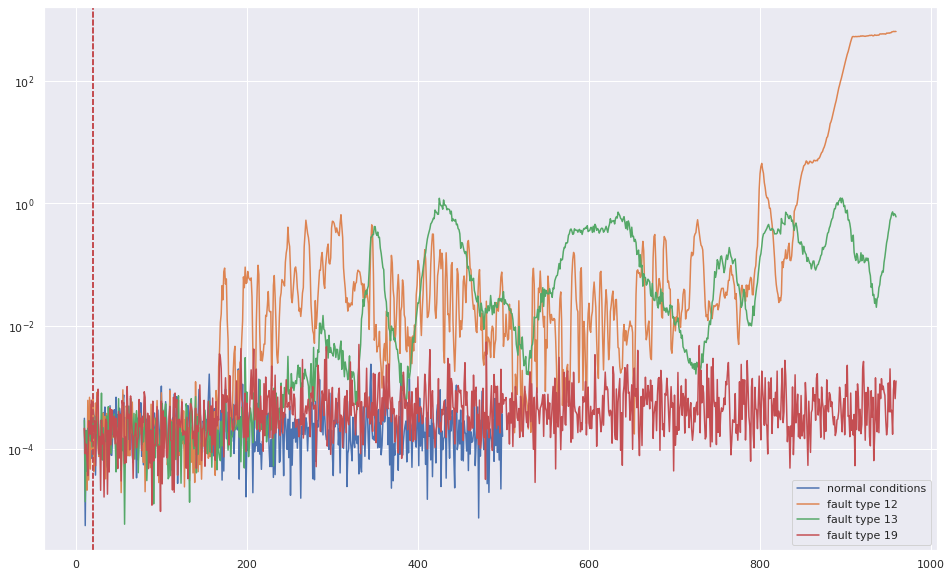

In [ ]:
plt.figure(figsize=(16,10))
plt.yscale('log')

for i in [0,12,13,19]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

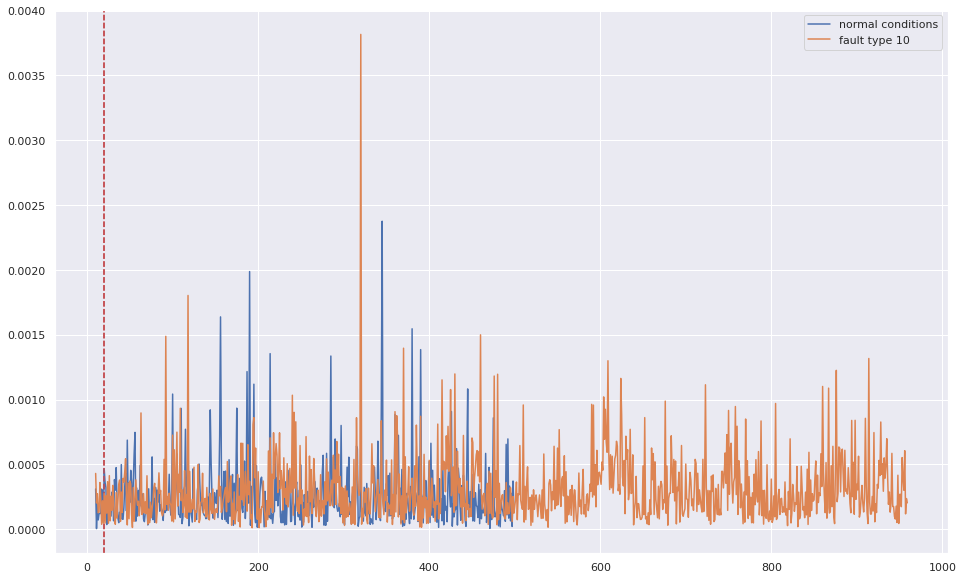

In [ ]:
plt.figure(figsize=(16,10))

for i in [0,10]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

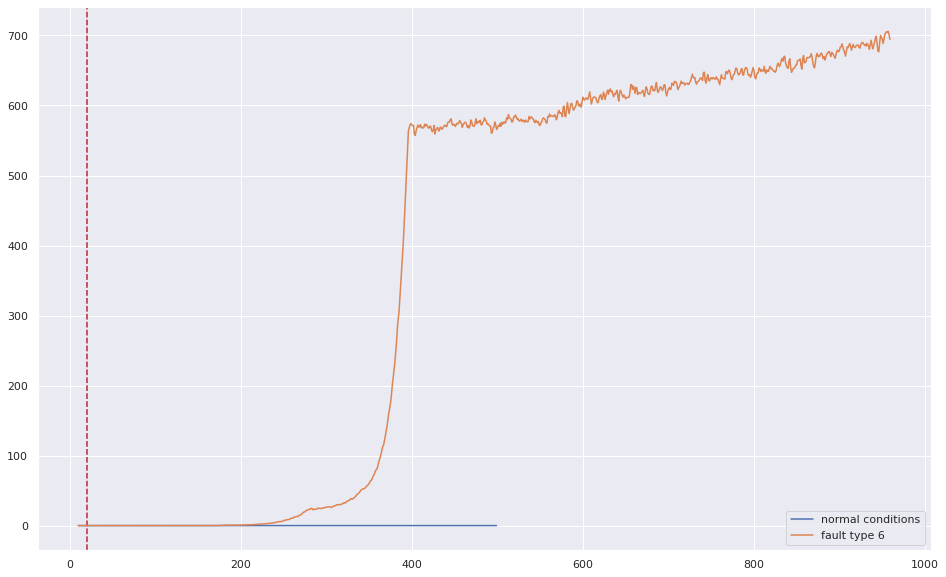

In [ ]:
plt.figure(figsize=(16,10))

for i in [0,6]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

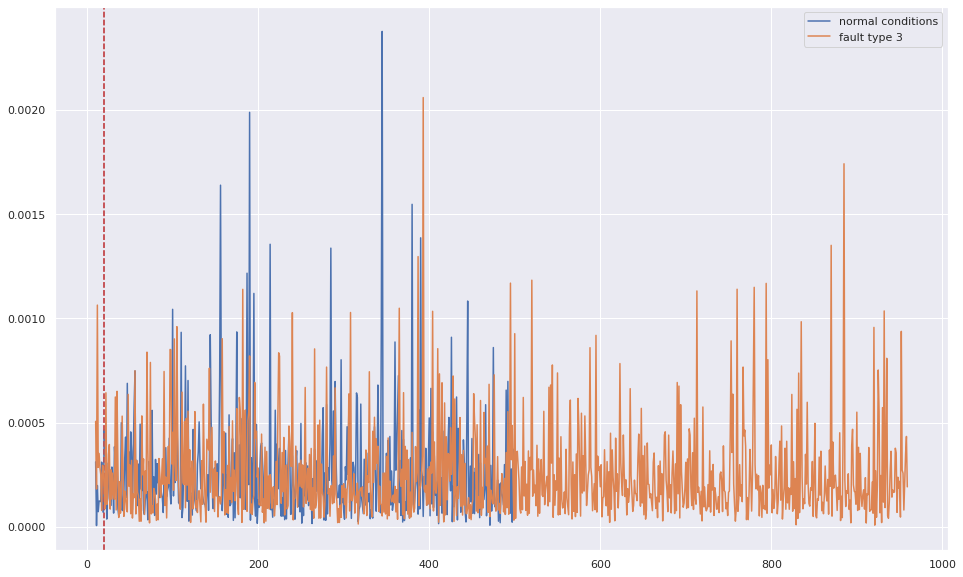

In [ ]:
plt.figure(figsize=(16,10))

for i in [0,3]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

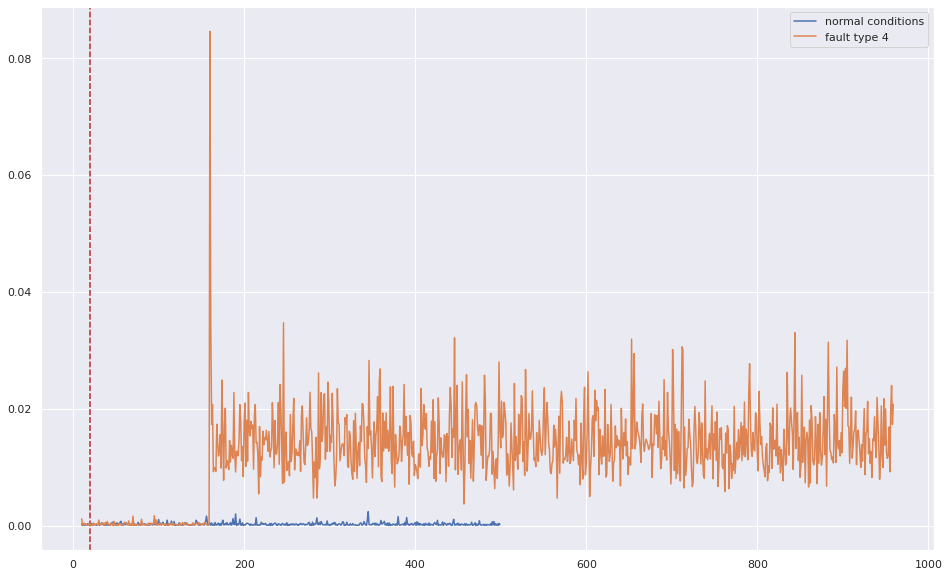

In [ ]:
plt.figure(figsize=(16,10))

for i in [0,4]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

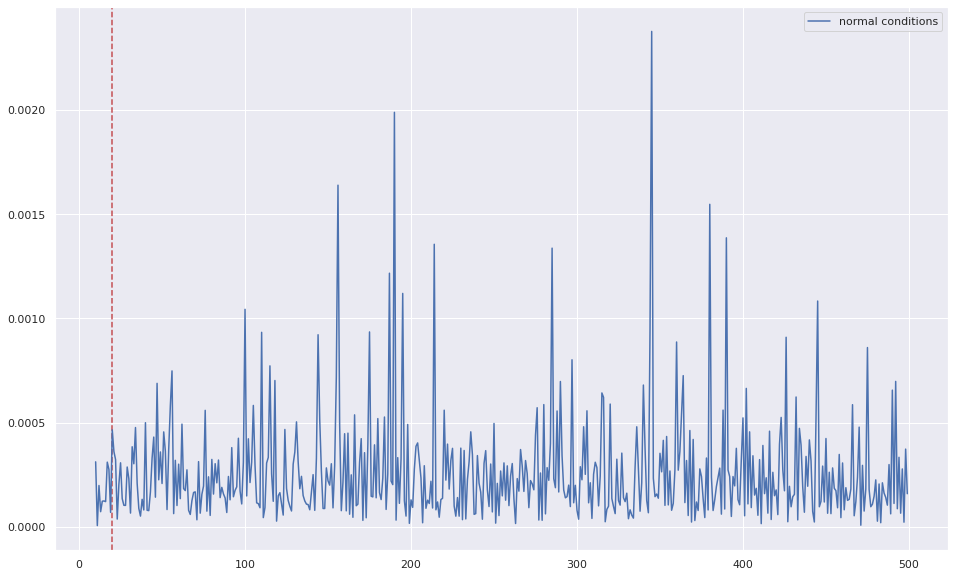

In [ ]:
plt.figure(figsize=(16,10))

for i in [0]:    
    if i == 0:
        test_sample = train_df[(train_df.simulationRun==500) & (train_df.faultNumber==i)].iloc[:,3:]
    else:
        test_sample = test_df[(test_df.simulationRun==np.random.randint(500)) & (test_df.faultNumber==i)].iloc[:,3:]
        
    test_sample = scaler.transform(test_sample)
    test_sample = series_to_lstm(test_sample,time_steps,1)
    
    test_x = test_sample.iloc[:,:-52]
    test_y = test_sample.iloc[:,-52:]
    test_x = test_x.values.reshape(test_x.shape[0],time_steps,test_x.shape[1]//time_steps)
    
    pred = model_lstm.predict(test_x)    
    
    plt.axvline(x=20,color='r',linestyle='--')
    if i==0:
        label='normal conditions'
    else:
        label='fault type %d' % i
    plt.plot(np.square((test_y.iloc[:,:]-pred[:,:])**2).mean(axis=1), label=label)
    plt.legend()

## References



*    https://github.com/camaramm/tennessee-eastman-profBraatz/blob/master/README.md#subroutines
*   https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1
*   https://colah.github.io/posts/2015-08-Understanding-LSTMs/
*   https://wiki.pathmind.com/lstm
*   https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/



## Future Work for Major Project
How the PCA unsupervised learning model works and apply it to the relevant failure detection problem. Generate two types of multivariate control charts, and , to plot contribution maps that indicate the variables most related to failures and to apply some pre-processing techniques that can improve the results in some cases